In [1]:
import sys
sys.path.append("/opt/anaconda3/lib/python3.11/site-packages")
import os
import git
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
!pip install pytorch-lightning
from torchmetrics import Accuracy 
from torch.utils.data import DataLoader, random_split
from pytorch_lightning import LightningModule, Trainer,loggers
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics.wrappers import Running
from torchmetrics.aggregation import MeanMetric

In [2]:
try:
    git.Repo.clone_from("https://github.com/yeswanthkaali/models.git", "/Users/yeswanth/Library/CloudStorage/OneDrive-SoftwareAG/Desktop(2)/era_v2/Assignment13/modules_assignment/")
except:
     repo = git.Repo('/Users/yeswanth/Library/CloudStorage/OneDrive-SoftwareAG/Desktop(2)/era_v2/Assignment13/modules_assignment/')
     reo = repo.remotes.origin
     reo.pull()


In [3]:
from modules_assignment.utils import train,test,lr_finder,plt_wrongpred
from modules_assignment.models.resnet18 import ResNet18

In [4]:
simple_transform=transforms.Compose([transforms.ToTensor()])
exp_dataset=datasets.CIFAR10('./data',train=True,download=True,transform=simple_transform)

Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(exp_dataset, batch_size=len(exp_dataset), shuffle=False)
data = next(iter(train_loader))

# Calculate mean and std per channel
mean = data[0].mean(dim=(0, 2, 3))  # Calculate mean across all images and height, width dimensions
std = data[0].std(dim=(0, 2, 3))    # Calculate std across all images and height, width dimensions

print("Mean per channel:", mean)
print("Std per channel:", std)
inv_normalize=transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)

Mean per channel: tensor([0.4914, 0.4822, 0.4465])
Std per channel: tensor([0.2470, 0.2435, 0.2616])


In [6]:
class Cifar10SearchDataset(datasets.CIFAR10):
    def __init__(self, root="~/data/cifar10", train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label
train_transform=A.Compose([A.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
                           A.RandomCrop (32, 32, always_apply=False, p=4),
                           A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value=None),
                            ToTensorV2()
                           
                                   ])
test_transform=A.Compose([A.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
                          ToTensorV2()
                                   ])
train_data=Cifar10SearchDataset('./data',train=True,download=True,transform=train_transform)
test_data=Cifar10SearchDataset('./data',train=False,download=True,transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

CUDA Available? False


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.89E-01


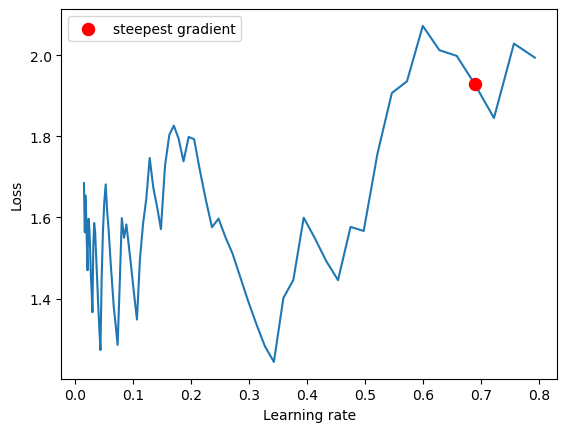

In [8]:
device = torch.device("mps")
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-2)
lr_finder(train_loader,optimizer,criterion,model,1)

In [9]:
class LitCIFAR(LightningModule):
    def __init__(self, data_dir='./data', hidden_size=16, learning_rate=2e-4):

        super().__init__()

        # Set our init args as class attributes
        self.data_dir = data_dir
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.criterion=nn.CrossEntropyLoss()
        self.running_loss = Running(MeanMetric(), window=10)



        # Hardcode some dataset specific attributes
        self.num_classes = 10
        self.train_transform=A.Compose([A.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
                                   A.RandomCrop (32, 32, always_apply=False, p=4),
                                   A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16, fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value=None),
                                    ToTensorV2()

                                           ])
        self.test_transform=A.Compose([A.Normalize((0.4914, 0.4822, 0.4465),(0.2470, 0.2435, 0.2616)),
                                  ToTensorV2()
                                           ])

        # Define PyTorch model
        self.model = ResNet18()

        self.accuracy = Accuracy(task='multiclass',num_classes=10)

    def forward(self, x):
        return self.model.forward(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss=self.criterion(logits, y)
        self.log("train_loss", loss.item(),  prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss=self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.accuracy(preds, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss.item(),  prog_bar=True, logger=True, on_step=False, on_epoch=True)
        self.log("val_acc",self.accuracy ,  prog_bar=True, logger=True, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.01, weight_decay=1e-7)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.689,total_steps=self.trainer.estimated_stepping_batches,div_factor=10,final_div_factor=10)
        return ([optimizer], [scheduler])

    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download
        Cifar10SearchDataset(self.data_dir, train=True, download=True)
        Cifar10SearchDataset(self.data_dir, train=False, download=True)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            cifar_full = Cifar10SearchDataset(self.data_dir, train=True, transform=self.train_transform)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.cifar_test = Cifar10SearchDataset(self.data_dir, train=False, transform=self.test_transform)

    def train_dataloader(self):
        return DataLoader(self.cifar_train, batch_size=512)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=512)

    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=512)

In [ ]:
from pytorch_lightning.callbacks import TQDMProgressBar
model = LitCIFAR()
trainer = Trainer(
    accelerator="mps", devices=1,
    max_epochs = 20,
    callbacks=[TQDMProgressBar(refresh_rate=1)],enable_progress_bar=True
)
trainer.fit(model)



GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Loading `train_dataloader` to estimate number of stepping batches.
/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

  | Name         | Type               | Params
----------------------------------------------------
0 | criterion    | CrossEntropyLoss   | 0     
1 | running_loss | Running            | 0     
2 | model        | ResNet             | 11.2 M
3 | accuracy     | MulticlassAccuracy | 0     
----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [31]:
test_data=trainer.test()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at /Users/yeswanth/Library/CloudStorage/OneDrive-SoftwareAG/Desktop(2)/era_v2/Assignment13/lightning_logs/version_29/checkpoints/epoch=5-step=528.ckpt
Loaded model weights from the checkpoint at /Users/yeswanth/Library/CloudStorage/OneDrive-SoftwareAG/Desktop(2)/era_v2/Assignment13/lightning_logs/version_29/checkpoints/epoch=5-step=528.ckpt


Testing: |                                                | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7231000065803528     │
│         val_loss          │     0.902914822101593     │
└───────────────────────────┴───────────────────────────┘

In [61]:
model_te = LitCIFAR.load_from_checkpoint("./cifarmodel.ckpt")
help(LitCIFAR().cifar_test)

AttributeError: 'LitCIFAR' object has no attribute 'cifar_test'

In [57]:
trainer.save_checkpoint("cifarmodel.ckpt")

In [32]:
print(test_data)

[{'val_loss': 0.902914822101593, 'val_acc': 0.7231000065803528}]


In [52]:
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import math
import numpy as np
def plt_wrongpred_gradcam(model,test_data,device,class_names,target_layers,inv_normalize,num_images):
    wrong_predictions = []
    x_count = 5
    y_count = 1 if num_images <= 5 else math.floor(num_images / x_count)
    with torch.no_grad():
        for data, target in test_data:
            #data, target = data.to(device), target
            output = model(data.unsqueeze(0))
            pred = torch.argmax(output, 1)# get the index of the max log-probability
            if(pred!=target):
                wrong_predictions.append((data, pred, target))
    device = "cpu"
    for i in range(1,min(num_images+1, len(wrong_predictions))):
        plt.subplot(y_count,x_count,i)
        plt.axis('off')
        image, predicted, label = wrong_predictions[i]
        device = torch.device("mps")
        image_ch=inv_normalize(image)
        image_ch = image_ch.to(device).permute(1, 2, 0)
        img = np.float32(image_ch.cpu())
        # Plot the image
        gm=gradcam(img,image.unsqueeze(0),model,target_layers)
        plt.imshow(gm)
        plt.title(f"output:{class_names[predicted]} \n actual:{class_names[label]}")
def gradcam(image,input_tensor,model,target_layers):
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(image, grayscale_cam, use_rgb=True)
    return visualization
def plt_wrongpred(model,test_data,device,class_names,num_images):
    x_count = 5
    y_count = 1 if num_images <= 5 else math.floor(num_images / x_count)
    wrong_predictions = []
    with torch.no_grad():
        for data, target in test_data:
            #data, target = data, target
            output = model(data.unsqueeze(0))
            pred = torch.argmax(output, 1)# get the index of the max log-probability
            if(pred!=target):
                wrong_predictions.append((data, pred, target))
    device = "cpu"
    for i in range(1,min(num_images+1, len(wrong_predictions))):
        plt.subplot(2,5,i)
        plt.axis('off')
        image, predicted, label = wrong_predictions[i]
        image = image.to(device).permute(1, 2, 0)  # Rearrange dimensions for plotting (assuming channels are last)    
        # Plot the image
        plt.imshow(image.clamp(0,1))
        plt.title(f"output:{class_names[predicted]} \n actual:{class_names[label]}")

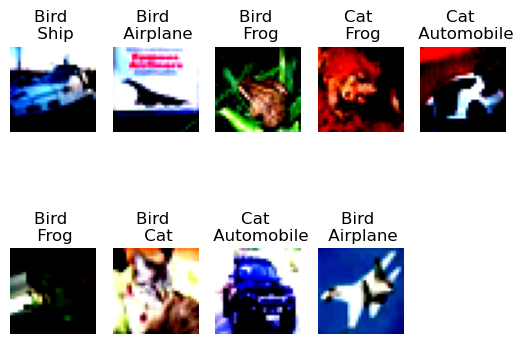

In [41]:
%matplotlib inline
target_layers=[model.model.layer3[-1]]
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt_wrongpred(model,model.cifar_test,device,class_names,10)

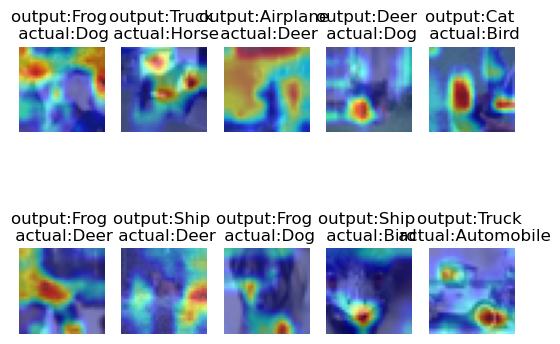

In [53]:
plt_wrongpred_gradcam(model,model.cifar_test,device,class_names,target_layers,inv_normalize,10)

In [45]:
%matplotlib inline
target_layers=[model.layer3[-1]]
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
model_eval=model.eval()
wrong_predictions = []
with torch.no_grad():
    for data, target in test_data:
        data, target = data.to(device), target
        output = model(data.unsqueeze(0))
        pred = torch.argmax(output, 1)# get the index of the max log-probability
        if(pred!=target):
            wrong_predictions.append((data, pred, target))

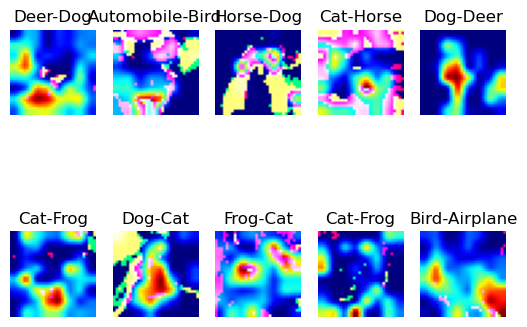

In [75]:
import numpy as np
target_layers=[model.layer3[-1]]
for i in range(1,min(11, len(wrong_predictions))):
    plt.subplot(2,5,i)
    plt.axis('off')
    image, predicted, label = wrong_predictions[i]
    device = torch.device("mps")
    image_ch = image.to(device).permute(1, 2, 0)  # Rearrange dimensions for plotting (assuming channels are last)
    img = np.float32(image_ch.cpu()) / 255
    # Plot the image
    gm=gradcam(img,image.unsqueeze(0),model,target_layers)
    plt.imshow(gm)
    plt.title(f"{class_names[predicted]}-{class_names[label]}")

In [ ]:
from PIL import Image


fig = plt.gcf()

img = fig2img(fig)

img.show()


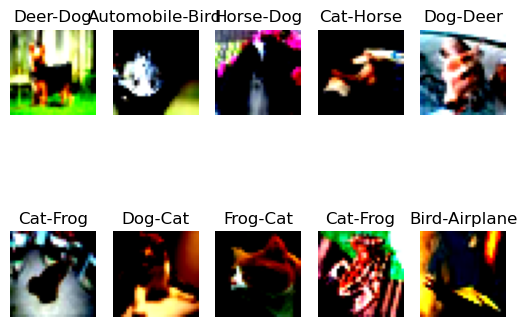

In [76]:
device = torch.device("cuda" if use_cuda else "cpu")
for i in range(1,min(11, len(wrong_predictions))):
    plt.subplot(2,5,i)
    plt.axis('off')
    image, predicted, label = wrong_predictions[i]
    image = image.to(device).permute(1, 2, 0)  # Rearrange dimensions for plotting (assuming channels are last)    
    # Plot the image
    plt.imshow(image.clamp(0,1))
    plt.title(f"{class_names[predicted]}-{class_names[label]}")

In [56]:
!pip install gradio
import torch, torchvision
from torchvision import transforms
import numpy as np
import gradio as gr
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

model = LitCIFAR.load_from_checkpoint("model.ckpt")
#model.load_state_dict(torch.load("model.pth", map_location=torch.device('cpu')), strict=False)

inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

def resize_image_pil(image, new_width, new_height):

    # Convert to PIL image
    img = Image.fromarray(np.array(image))
    
    # Get original size
    width, height = img.size

    # Calculate scale
    width_scale = new_width / width
    height_scale = new_height / height 
    scale = min(width_scale, height_scale)

    # Resize
    resized = img.resize((int(width*scale), int(height*scale)), Image.NEAREST)
    
    # Crop to exact size
    resized = resized.crop((0, 0, new_width, new_height))

    return resized

def inference(input_img, transparency = 0.5, target_layer_number = -1):
    input_img = resize_image_pil(input_img, 32, 32)
    
    input_img = np.array(input_img)
    org_img = input_img
    input_img = input_img.reshape((32, 32, 3))
    transform = transforms.ToTensor()
    input_img = transform(input_img)
    input_img = input_img
    input_img = input_img.unsqueeze(0)
    outputs = model(input_img)
    softmax = torch.nn.Softmax(dim=0)
    o = softmax(outputs.flatten())
    confidences = {classes[i]: float(o[i]) for i in range(10)}
    _, prediction = torch.max(outputs, 1)
    target_layers = [model.layer2[target_layer_number]]
    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_img, targets=None)
    grayscale_cam = grayscale_cam[0, :]
    img = input_img.squeeze(0)
    img = inv_normalize(img)
    print(transparency)
    visualization = show_cam_on_image(org_img/255, grayscale_cam, use_rgb=True, image_weight=transparency)
    return classes[prediction[0].item()], visualization, confidences

title = "CIFAR10 trained on ResNet18 Model with GradCAM"
description = "A simple Gradio interface to infer on ResNet model, and get GradCAM results"
examples = [["cat.jpg", 0.5, -1], ["dog.jpg", 0.5, -1]]
demo = gr.Interface(
    inference, 
    inputs = [
        gr.Image(width=256, height=256, label="Input Image"),gr.Dropdown(choices=[True,False],label="GradCamImage"),gr.Slider
        (0, 1, value = 0.5, label="Overall Opacity of Image"), 
        gr.Slider(-2, -1, value = -2, step=1, label="Which Layer?"),
        gr.TextBox
        ], 
    outputs = [
        "text", 
        gr.Image(width=256, height=256, label="Output"),
        gr.Label(num_top_classes=3)
        ],
    title = title,
    description = description,
    examples = examples,
)
demo.launch()

ImportError: cannot import name 'SpaceHardware' from 'huggingface_hub' (/Users/yeswanth/anaconda3/lib/python3.10/site-packages/huggingface_hub/__init__.py)